# Monitor NB - Penthesilea - Th


### Imports 

In [1]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import scipy.stats       as stats
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

import invisible_cities.icaro.hst_functions as hst

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units

Running on  Thu Oct  5 02:08:31 2017


In [2]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

# Code

### utils

In [3]:
def fselection(sels):
    """ makes the all of different selections
    """
    return functools.reduce(lambda x, y: np.logical_and(x, y), sels)

In [4]:
input_folder  = '/Users/hernando/investigacion/NEXT/data/run2'
tags = '/prod/may17/alex'

def load_dst(run_number, tags='/prod/may17/alex'):
    """ load dst and return full data, train and test selections
    """
    inputfilename = input_folder + "/{0}{1}/dst/dst_{0}.root.h5".format(run_number, tags)
    print('load dst ', inputfilename)
    data = dstf.load_dst(inputfilename, "DST", "Events")
    return data
    #data.head()

### Histogramming

In [5]:
xbins  = 100
xybins = (40, 40)
range_none = (0., 0.)

def mh1(data, varname, bins=xbins, range=range_none, fig=None, ax=None):
    if (not ax):
        fig, ax = plt.subplots()
    dat = getattr(data, varname)
    ns = len(dat)
    if (range[0] >= range[1]):
        range = np.min(dat), np.max(dat)
    cc = ax.hist(dat, bins, range=range)
    counts, edges = cc[0], cc[1]
    xpos = edges[0]+0.6*(edges[-1]-edges[0])
#    ypos = np.min(counts)+0.7*(np.max(counts)-np.min(counts))
    ypos = 0.7*np.max(counts)
    sel = np.logical_and(dat > range[0], dat < range[1])
    ss = stats.describe(dat[sel])
    nos, mean, rms = int(ss.nobs), float(ss.mean), float(np.sqrt(ss.variance))  
    epsilon = (1.*nos)/(1.*ns)
    ss  = ' $\epsilon$ = {0:.3f} \n $n$ = {1:}'.format(epsilon, nos)
    ss += ' \n $\mu$ = {0:.3f} \n $\sigma$ = {1:.3f}'.format(mean, rms)
    ax.text(xpos, ypos, ss, fontsize=11)
    # ax.text(xpos, ypos, dat[sel].describe(), fontsize=11)
    # fig.text(1., 0.2, dat[sel].describe())
    ax.set_xlabel(varname)
    return

def mh2(data, xvar, yvar, bins=xybins, range=(range_none, range_none), 
        fig=None, ax=None):
    # get data, ranges, axis
    if (ax == None):
        fig, ax = plt.subplots()
    xs, ys = getattr(data, xvar), getattr(data, yvar)
    xrange, yrange = range
    if (xrange[0] >= xrange[1]):
        xrange = np.min(xs), np.max(xs)
    if (yrange[0] >= yrange[1]):
        yrange = np.min(ys), np.max(ys)
    # 2d histogram
    cc = ax.hist2d(xs, ys, bins=bins, range=(xrange, yrange), cmap='jet')
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    fig.colorbar(cc[-1], ax=ax)
    sel = fselection([xs > xrange[0], xs < xrange[1],
                      ys > yrange[0], ys < yrange[1]])
    # profile
    px, py, pk = fitf.profileX(xs[sel], ys[sel], bins[0], 
                               xrange=xrange, yrange=yrange)
    ax.plot(px, py, profOpt)
    # stats
    ss1 = stats.describe(xs[sel])
    ss2 = stats.describe(ys[sel])
    nobs, mu1, sig1 = ss1.nobs, ss1.mean, np.sqrt(ss1.variance)
    nobs, mu2, sig2 = ss2.nobs, ss2.mean, np.sqrt(ss2.variance)
    corr = np.corrcoef(xs[sel], ys[sel])
    # print(corr)
    ypos = yrange[0]+0.5*(yrange[1]-yrange[0])
    xpos = xrange[0]+0.6*(xrange[1]-xrange[0])
    n = len(data)
    epsilon = (1.*nobs)/(1.*n)
    ss  = " $\epsilon$ = {0:.3f} \n $n$ = {1:}".format(epsilon, nobs) 
    ss += "\n $\mu_x$ = {0:.3f} \n $\sigma_x$ = {1:.3f}".format(mu1, sig1)
    ss += "\n $\mu_y$ = {0:.3f} \n $\sigma_y$ = {1:.3f}".format(mu2, sig2)
    ss += "\n "+r"$\rho$ = {0:.3f} ".format(float(corr[0, 1]))
    # print(ss)
    ax.text(xpos, ypos, ss, fontsize=11, color='white')
    return

def plt_hist(data, vars):
    ns = int(len(vars)/2)
    if (2*ns < len(vars)): 
        ns = ns+1 
    fig, axs = plt.subplots(ns, 2, figsize=(5.5*2, 4.5*ns))
    axs = axs.ravel()
    for i, var in enumerate(vars):
        if (len(var) == 3):
            mh1(data, var[0], bins=var[-2], range=var[-1], 
                fig = fig, ax=axs[i])
        else:
            mh2(data, var[0], var[1], bins=var[-2], range=var[-1], 
                fig = fig, ax=axs[i])
    fig.tight_layout()
    return fig

## Read the corrections table
Reads the corrections table from the specified file and creates a function that returns the correction factor for a given (x,y) location.

In [10]:
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/run4446_corrections_5.3mm.h5"
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/run4628_corrections_5.3mm.h5"
ncbins = 74 # 54
tbl_ext = 195.36 # 215

Correction table with shape: (75, 75); bin sizes (5.279998779296875,5.279998779296875)


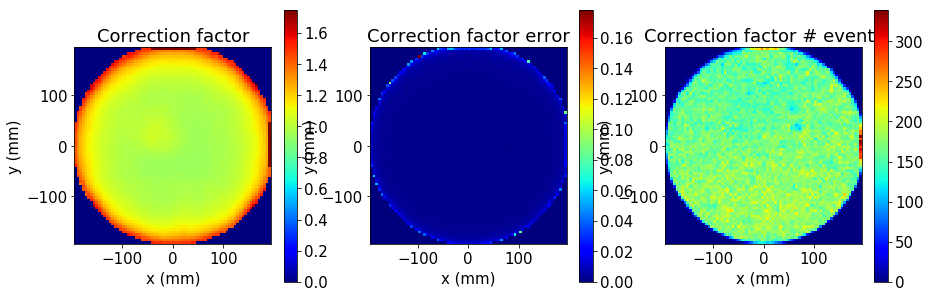

In [11]:
fcorr = tb.open_file(corr_file,'r')

# Fill arrays containing the information in the correction table.
corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

# ---------------------------------------------
# Plots

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-tbl_ext, tbl_ext), (-tbl_ext, tbl_ext)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-tbl_ext, tbl_ext), (-tbl_ext, tbl_ext)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics
ax3 = fig.add_subplot(133)
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-tbl_ext, tbl_ext), (-tbl_ext, tbl_ext)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

# ---------------------------------------------------
# Create the correction factor table.

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))

# Define a function that returns the correction factor for a given (x,y).
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Data

In [12]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through the nonNN dictionary and update the energies including the NN hits from the "all" dictionary.
    for (evt,hc) in hits_nonNN.items():

        # Get the corresponding collection of all hits.
        hc_all = hits_all[evt]
            
        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)
                    
        # Check the sum of the energy.
        #e1 = sum([hh.E for hh in hc_all.hits])
        #e2 = sum([hh.E for hh in hc.hits])
        #if(abs(e1 - e2) > 0.001):
        #    print("ERROR")

In [13]:
# run numbers and lifetime values for correction
l_rnum   = [4717]
l_tlife  = [1598]
l_nfiles = [5]

In [8]:
l_hitc = []; l_tlife_hitc = []
for rnum,tlife,nfile in zip(l_rnum,l_tlife,l_nfiles):
    
    print("Loading hits from {0} files of run {1}".format(nfile,rnum))
    
    for rr in range(nfile):
        
        # Fill run number with zeros if necessary.
        rstr = rr
        if(rr < 10):
            rstr = '00{0}'.format(rstr)
        elif(rr < 100):
            rstr = '0{0}'.format(rstr)
        
        fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks.gdcsnext.{1}_{2}.root.h5".format(rnum,rstr,rnum)
        if(os.path.isfile(fname)):
            hits_all = load_hits(fname)
            hits = load_hits_skipping_NN(fname)

            # Modifies the list of non-NN hits.
            merge_NN_hits(hits_all,hits)

            # Save the hit collection that no longer contains NN hits.
            l_hitc.append(hits)
            l_tlife_hitc.append(tlife)
        else:
            print("File {0} does not exist: skipping...".format(fname))

Loading hits from 5 files of run 4717


In [14]:
# Create the corrected hit collections (summed over all runs) for 
#  fully corrected (c), geometry-only corrected (g), tau-only corrected (t), and uncorrected (u) events.
hitc_uevt = []; hitc_cevt = []; hitc_gevt = []; hitc_tevt = []
for hitc, tlife in zip(l_hitc,l_tlife_hitc):

    for ee,hc in hitc.items():
        hc_ucorr = []; hc_corr = []; hc_gcorr = []; hc_tcorr = []
        for hh in hc.hits:
            
            hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
            hegcorr = hh.E*fcorr(hh.X,hh.Y)
            hetcorr = hh.E/np.exp(-hh.Z/tlife)
            
            hucorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hh.E)
            hcorr  = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hgcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hegcorr)
            htcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hetcorr)
            
            hc_ucorr.append(hucorr); hc_corr.append(hcorr); hc_gcorr.append(hgcorr); hc_tcorr.append(htcorr)
        
        # Only save events with >= 2 hits.
        if(len(hc_corr) >= 2):
            hitc_uevt.append(hc_ucorr)
            hitc_cevt.append(hc_corr)
            hitc_gevt.append(hc_gcorr)
            hitc_tevt.append(hc_tcorr)

In [16]:
A_Ec = []; A_Ec_avg = []; A_Ec_tau = []; A_Ec_geo = []; A_E0 = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []

for ee in range(len(hitc_cevt)):
    
    # Compute the corrected energy and average coordinates.
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(evt_E > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Compute the energy with other corrections.
    evt_E_uncorr = sum([hh.E for hh in hitc_uevt[ee]])
    evt_E_cgeo = sum([hh.E for hh in hitc_gevt[ee]])
    evt_E_ctau = sum([hh.E for hh in hitc_tevt[ee]])
    
    # Add to distributions.
    A_Ec.append(evt_E)
    A_Ec_avg.append(evt_E_uncorr*fcorr(evt_X,evt_Y)/np.exp(-evt_Z/tlife))
    A_Ec_tau.append(evt_E_ctau)
    A_Ec_geo.append(evt_E_cgeo)
    A_E0.append(evt_E_uncorr)
    A_xavg.append(evt_X)
    A_yavg.append(evt_Y)
    A_zavg.append(evt_Z)
    A_ravg.append(evt_R)

# Convert to numpy arrays.
A_Ec = np.array(A_Ec)
A_Ec_avg = np.array(A_Ec_avg)
A_Ec_tau = np.array(A_Ec_tau)
A_Ec_geo = np.array(A_Ec_geo)
A_E0 = np.array(A_E0)
A_xavg = np.array(A_xavg)
A_yavg = np.array(A_yavg)
A_zavg = np.array(A_zavg)
A_ravg = np.array(A_ravg)

print("Events in key quantities: {0}".format(len(A_Ec)))

Events in key quantities: 513


# Monitoring plots

## General